<a href="https://colab.research.google.com/github/kstyle2198/NLP_TIPS/blob/main/Building_Language_Models_A_Step_by_Step_BERT_Implementation_Guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://medium.com/@erkajalkumari/building-language-models-a-step-by-step-bert-implementation-guide-96c9930b9536

# Import Required Libraries & Dataset

In [38]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

In [39]:
# specify GPU
device = torch.device("cuda")

In [40]:
from google.colab import files
uploaded = files.upload()

Saving financial_data.csv to financial_data (2).csv


In [41]:
df = pd.read_csv("financial_data.csv")
df.shape

(5842, 2)

In [42]:
df.columns = ["text", "label"]
df.head(2)

,text,label
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative


In [43]:
# check class distribution
df['label'].value_counts(normalize = True)

neutral     0.535775
positive    0.317015
negative    0.147210
Name: label, dtype: float64

### 본 연습 목적상 라벨을 바이너리로

In [44]:
df = df[df["label"].isin(["positive", "negative"])]
df = df.replace(to_replace=["positive", "negative"], value=[0, 1])

In [45]:
df['label'].value_counts(normalize = True)

0    0.682891
1    0.317109
Name: label, dtype: float64

# Split the Dataset into train/test

In [46]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])
train_text.shape, temp_text.shape, train_labels.shape, temp_labels.shape

((1898,), (814,), (1898,), (814,))

In [47]:
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)
val_text.shape, test_text.shape, val_labels.shape, test_labels.shape

((407,), (407,), (407,), (407,))

# Import BERT-Base-Uncased

In [48]:
model_name = 'bert-base-uncased'
# import BERT-base pretrained model
bert = AutoModel.from_pretrained(model_name)
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name)

In [49]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
seq_len[:5]

[9, 44, 13, 43, 21]

<Axes: >

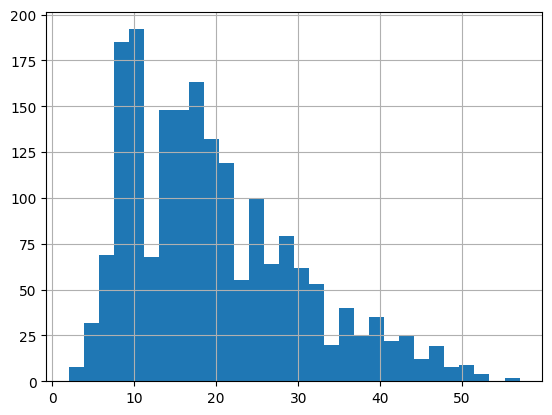

In [50]:
pd.Series(seq_len).hist(bins = 30)

# Tokenize & Encode the Sequences

In [51]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [52]:
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

In [53]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

In [54]:
train_labels

5581    1
1987    1
3442    0
3677    1
4947    0
       ..
4126    0
1852    0
5124    1
5041    0
2149    0
Name: label, Length: 1898, dtype: int64

# List to Tensors

In [55]:
## convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Data Loader

In [56]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [57]:
#define a batch size
batch_size = 32
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Model Architecture

In [58]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [59]:
class BERT_Arch(nn.Module):
  def __init__(self, bert):
    super(BERT_Arch, self).__init__()
    self.bert = bert
    # dropout layer
    self.dropout = nn.Dropout(0.1)
    # relu activation function
    self.relu =  nn.ReLU()
    # dense layer 1
    self.fc1 = nn.Linear(768,512)
    # dense layer 2 (Output layer)   ##### 라벨 개수에 따라 수정해야 하는 부분
    self.fc2 = nn.Linear(512,2)
    #softmax activation function
    self.softmax = nn.LogSoftmax(dim=1)

  #define the forward pass
  def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)
      return x

# GPU Acceleration

In [60]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [61]:
# optimizer from hugging face transformers
from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [62]:
!pip install scikit-learn==1.3.2

In [63]:
# 에러관련 참고 링크 : https://street-developer.tistory.com/11

from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
print("Class Weights:",class_weights)

Class Weights: [0.73225309 1.57641196]


In [64]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

In [65]:
# push to GPU
weights = weights.to(device)
# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)
# number of training epochs
epochs = 10

# Fine-Tune

In [66]:
# function to train the model
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
    # append the model predictions
    total_preds.append(preds)
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    #returns the loss and predictions
    return avg_loss, total_preds

In [67]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()


    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        # push the batch to gpu
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

# Train the Model

In [68]:
# set initial loss to infinite
best_valid_loss = float('inf')

In [75]:
#defining epochs
epochs = 50
# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 50
  Batch    50  of     60.

Evaluating...

Training Loss: 0.687
Validation Loss: 0.682

 Epoch 2 / 50
  Batch    50  of     60.

Evaluating...

Training Loss: 0.685
Validation Loss: 0.678

 Epoch 3 / 50
  Batch    50  of     60.

Evaluating...

Training Loss: 0.682
Validation Loss: 0.679

 Epoch 4 / 50
  Batch    50  of     60.

Evaluating...

Training Loss: 0.682
Validation Loss: 0.673

 Epoch 5 / 50
  Batch    50  of     60.

Evaluating...

Training Loss: 0.678
Validation Loss: 0.673

 Epoch 6 / 50
  Batch    50  of     60.

Evaluating...

Training Loss: 0.677
Validation Loss: 0.669

 Epoch 7 / 50
  Batch    50  of     60.

Evaluating...

Training Loss: 0.673
Validation Loss: 0.666

 Epoch 8 / 50
  Batch    50  of     60.

Evaluating...

Training Loss: 0.669
Validation Loss: 0.663

 Epoch 9 / 50
  Batch    50  of     60.

Evaluating...

Training Loss: 0.667
Validation Loss: 0.660

 Epoch 10 / 50
  Batch    50  of     60.

Evaluating...

Training Loss: 0.667
Validation L

In [76]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Make Predictions

In [77]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [78]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       278
           1       0.51      0.59      0.54       129

    accuracy                           0.69       407
   macro avg       0.65      0.66      0.65       407
weighted avg       0.70      0.69      0.69       407



             precision    recall  f1-score   support

           0       0.73      0.50      0.59       278
           1       0.36      0.59      0.44       129

    accuracy                           0.53       407
   macro avg       0.54      0.55      0.52       407
weighted avg       0.61      0.53      0.55       407